In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.0 MB/s eta 0:00:00


In [ ]:
pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=cfcaae404f73f8f682507f0a9f949490a93a53813cd3e5995503e305c55ab11a
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import os
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import HerbertTokenizer, RobertaModel, AutoTokenizer, BertModel

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb


In [ ]:
herbert_large = ["Herbert-large", HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"), RobertaModel.from_pretrained("allegro/herbert-large-cased")]
herbert_base = ["Herbert-base", HerbertTokenizer.from_pretrained("allegro/herbert-base-cased"), RobertaModel.from_pretrained("allegro/herbert-base-cased")]
herbert_klej = ["Herbert-klej", HerbertTokenizer.from_pretrained("allegro/herbert-klej-cased-tokenizer-v1"), RobertaModel.from_pretrained("allegro/herbert-klej-cased-v1")]

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing RobertaModel: ['bert.encoder.layer.14.attention.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.self.value.bias', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.5.attention.self.key.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.3.attention.output.dense.bias', 'bert.encoder.layer.9.intermediate.dense.weight', 'cls.sso.sso_relationship.weight', 'bert.encoder.layer.17.intermediate.dense.weight', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.20.attention.output.LayerNorm.bias', 'bert.encoder.layer.14.intermediate.dense.weight', 'bert.encoder.layer.12.attention.output.dense.weight', 'bert.encoder.layer.18.attention.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.output.dense.bias', 'bert.encoder.layer.16.attention.self.query.weight', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.4.a

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing RobertaModel: ['bert.encoder.layer.9.attention.self.query.bias', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.value.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.4.output.dense.weight', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.8.attention.output.dense.bias', 'bert.encoder.layer.11.attention.self.key.bias', 'bert.encoder.layer.10.attention.self.value.bias', 'bert.encoder.layer.4.attention.self.value.bias', 'bert.encoder.layer.9.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.1.output.dense.bias', 'bert.encoder.layer.7.output.dense.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMTokenizer'. 
The class this function is called from is 'HerbertTokenizer'.


In [ ]:
def draw_learning_curve(history, key='accuracy'):

  fig, ax = plt.subplots(1, 2, figsize=(12,6))
  ax[0].plot(history.history[key])
  ax[0].plot(history.history['val_'+ key] )
  ax[0].set_ylabel(key.title())
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'])

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'] )
 # ax[1].set_ylim([0,1])
  ax[1].set_ylabel('loss'.title())
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'])
  fig.suptitle('Learning curve')
  plt.show()

In [ ]:
def run_models(X_train,  X_test, y_train, y_test, data_type, classes):

  cls =[]
  for k in classes.keys():
    cls.append(k)

  models = [
      ["decision_tree", DecisionTreeClassifier(max_depth=20)],
      ["random_forest", RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)],
      ["xgboost", xgb.XGBClassifier(n_estimators=100, random_state=0)],
      ["lgbm", lgb.LGBMClassifier(n_estimators=50, random_state=0, max_depth=10)]
  ]

  scores_dict = {}
  for model_name, model_clf in models:

    scores = model_clf.fit(X_train, y_train)
    y_pred = model_clf.predict(X_test)
    num_classes = len(classes)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
    disp.plot()
    disp.ax_.set_title("Model: {} | Data type: {} |  Acc: {}".format(model_name, data_type, score))

    if classes is not None:
      tick_marks = np.arange(len(cls))
      plt.xticks(tick_marks, cls, rotation=45)
      plt.yticks(tick_marks, cls, rotation=50)

    plt.gcf().set_size_inches(10, 10)
    plt.savefig('/content/figs/{}_{}.png'.format(model_name, data_type), dpi=200)
    #files.download('/content/figs/{}_{}.png'.format(model_name, data_type))
    scores_dict[model_name] = score
  return scores_dict


In [ ]:
def print_classes(df):
  y = df["Label"]
  authors = {}
  num_classes = len(df['Label'].unique())
  if(num_classes < 8):
    y = df["Label"].factorize()[0]

  for label in range(0, num_classes):
    i, = np.where(y == label)
    authors['{}'.format(df['Author-short'][i[0]])] = label

  return authors

In [ ]:
def get_data_set(labels, df):
  idxs = []
  for label in labels:
    idxs_for_label, = np.where(df['Label'] == label)
    for idx in idxs_for_label:
      idxs.append(idx)

  new_df = df.iloc[idxs]
  new_df = new_df.sample(frac = 1).reset_index(drop=True)
  return new_df

In [ ]:
def get_X_y_train(df, normalize=False):

  X = np.stack(df['embedding'])
  y = df['Label']
  if(normalize == True):
    X = normalize_data(X)

  #jeśli jest mniej niż 8 klas:
  if len(df['Label'].unique()) < 8:
    y = df ['Label'].factorize()[0]

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


  print(X.shape)

  return X, y, X_train, X_val, y_train, y_val

In [ ]:
def make_embedding(df, model):

  X_stack = []

  model_name, tokenizer, model = model
  embedded = {}
  num_idxs = df.shape[0]
  for idx in tqdm(range(0,num_idxs)):
    single_poem_input = df['Text'][idx]
    inputs = tokenizer.batch_encode_plus([single_poem_input], max_length = 512, padding="longest", add_special_tokens=True, return_tensors="pt",)
    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])

    embedded[idx] = X_single_poem[0], df['Label'][idx]

  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['embedding', 'label'])

  return df_embedded

In [ ]:
def normalize_data(X):

  X_normalized = np.zeros((X.shape[0],X.shape[1]))

  for idx in range(0,X.shape[0]):
    X_normalized[idx,:] = (X[idx,:] - np.mean(X[idx,:]))/ np.std(X[idx,:])

  return X_normalized

In [ ]:
os.mkdir('figs')

In [ ]:
df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")
df_raw .columns

<ipython-input-11-856413025014>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_raw = pd.read_csv('/content/wiersze_do_BERT_Herbert_Miłosz.csv', ";")


Index(['Author', 'Author-short', 'Title', 'Text', 'From', 'Note', 'Words',
       'Label', 'Gender', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

In [ ]:
df_raw  = df_raw .drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'])
df_raw.shape

(450, 9)

In [ ]:
df_raw = df_raw.drop(df_raw.index[400:])
df_raw

,Author,Author-short,Title,Text,From,Note,Words,Label,Gender
0,Jan Kochanowksi,J. Kochanowki,Pieśń III,"Nie wierz Fortunie, co siedzisz wysoko; Miej n...",Księgi wróte,NaN,147.0,0.0,0.0
1,Jan Kochanowksi,J. Kochanowki,Pieśń IV,W twardej kamiennej wieży i za troistemi Drzwi...,Księgi wróte,NaN,250.0,0.0,0.0
2,Jan Kochanowksi,J. Kochanowki,Pieśń V,"Wieczna sromota i nienagrodzona Szkoda, Polaku...",Księgi wróte,NaN,250.0,0.0,0.0
3,Jan Kochanowksi,J. Kochanowki,Pieśń VI,"Królewno lutnie złotej i rymów pociesznych, Oc...",Księgi wróte,NaN,109.0,0.0,0.0
4,Jan Kochanowksi,J. Kochanowki,Pieśń IX,"Nie porzucaj nadzieje, Jakoć sie kolwiek dziej...",Księgi wróte,NaN,143.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
395,Ewa Lipska,E. Lipska,Wielki Odkrywco Wyobraźni,Wielki Odkrywco Wyobraźni na rybiookich wspart...,NaN,NaN,106.0,7.0,1.0
396,Ewa Lipska,E. Lipska,Wyznanie mężczyzny od którego kobieta odchodzi...,Odchodzisz ode mnie jak lato. I powracasz do m...,NaN,NaN,109.0,7.0,1.0
397,Ewa Lipska,E. Lipska,Z listu (II),I jak tu popełnić samobójstwo droga pani kiedy...,NaN,NaN,63.0,7.0,1.0
398,Ewa Lipska,E. Lipska,Wolny przekład z Szekspira,W oczy mi patrzysz wciąż tak samo jak w tysiąc...,NaN,NaN,143.0,7.0,1.0


In [ ]:
df_women = df_raw[200:]
df_men = df_raw[:200]
df_women = df_women.sample(frac = 1).reset_index(drop=True)
df_men = df_men.sample(frac = 1).reset_index(drop=True)

In [ ]:
df_orginal = pd.DataFrame
df_orginal = pd.concat([df_raw["Text"],df_raw["Label"],df_raw["Author-short"]], axis=1)
df_orginal = df_orginal.sample(frac = 1).reset_index(drop=True)
df_orginal

In [ ]:
embedding = make_embedding(df_orginal, herbert_klej)
df_orginal = pd.concat([df_orginal, embedding['embedding']], axis=1)
df_orginal

In [ ]:
embedding_men = make_embedding(df_men, herbert_klej)
df_men = pd.concat([df_men, embedding_men['embedding']], axis=1)
df_men

In [ ]:
embedding_women = make_embedding(df_women, herbert_klej)
df_women = pd.concat([df_women, embedding_women['embedding']], axis=1)
df_women

In [ ]:
def run_models(X_train, y_train, X_test, y_test, data_type, classes):

  cls = []
  for k in classes.keys():
    cls.append(k)

  models = [
      ["decision_tree", DecisionTreeClassifier(max_depth=20)],
      #["random_forest", RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)],
      #["xgboost", xgb.XGBClassifier(n_estimators=100, random_state=0)],
      #["lgbm", lgb.LGBMClassifier(n_estimators=50, random_state=0, max_depth=10)]
  ]


  for model_name, model_clf in models:

    scores = model_clf.fit(X_train, y_train)
    y_pred = model_clf.predict(X_test)
    num_classes = len(classes)
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
    disp.plot()
    disp.ax_.set_title("Model: {} | Data type: {} | Acc: {}".format(model_name, data_type, score))

    if classes is not None:
        tick_marks = np.arange(len(cls))
        plt.xticks(tick_marks, cls, rotation=45)
        plt.yticks(tick_marks, cls, rotation=50)

    plt.gcf().set_size_inches(10, 10)
    #plt.savefig('/content/figs/{}_{}_{}_classes.png'.format(model_name, data_type, num_classes), dpi=200)
    #files.download('/content/figs/{}_{}_{}_classes.png'.format(model_name, data_type, num_classes))

  return score, cm

(200, 768)
(200, 768)
(200, 768)
(200, 768)
(200, 768)
(200, 768)
(200, 768)
(200, 768)
(200, 768)
(200, 768)


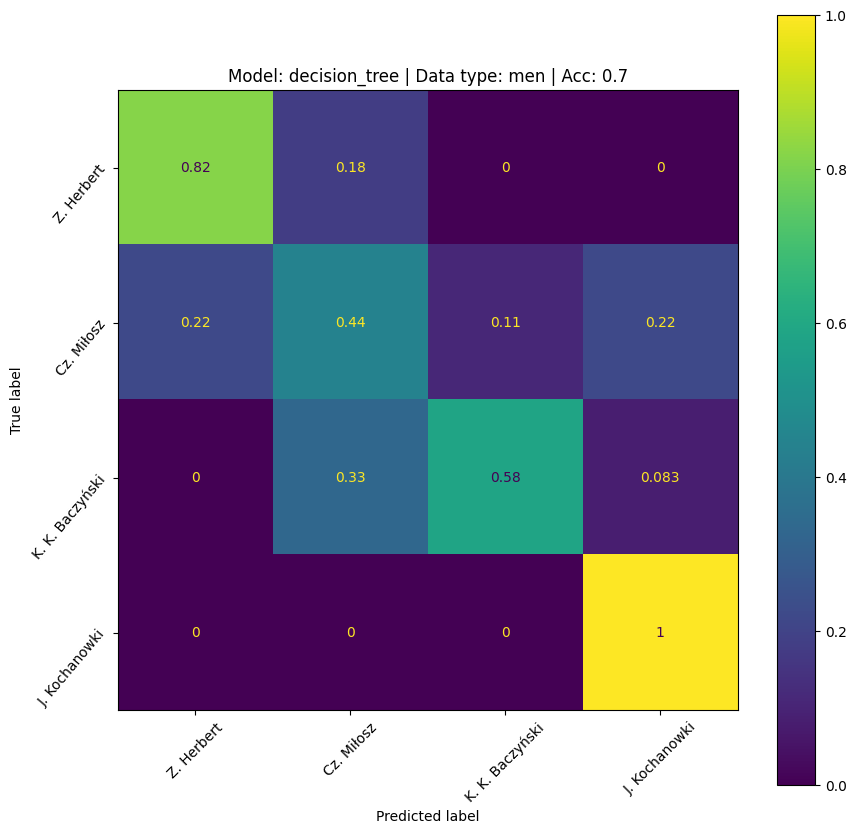

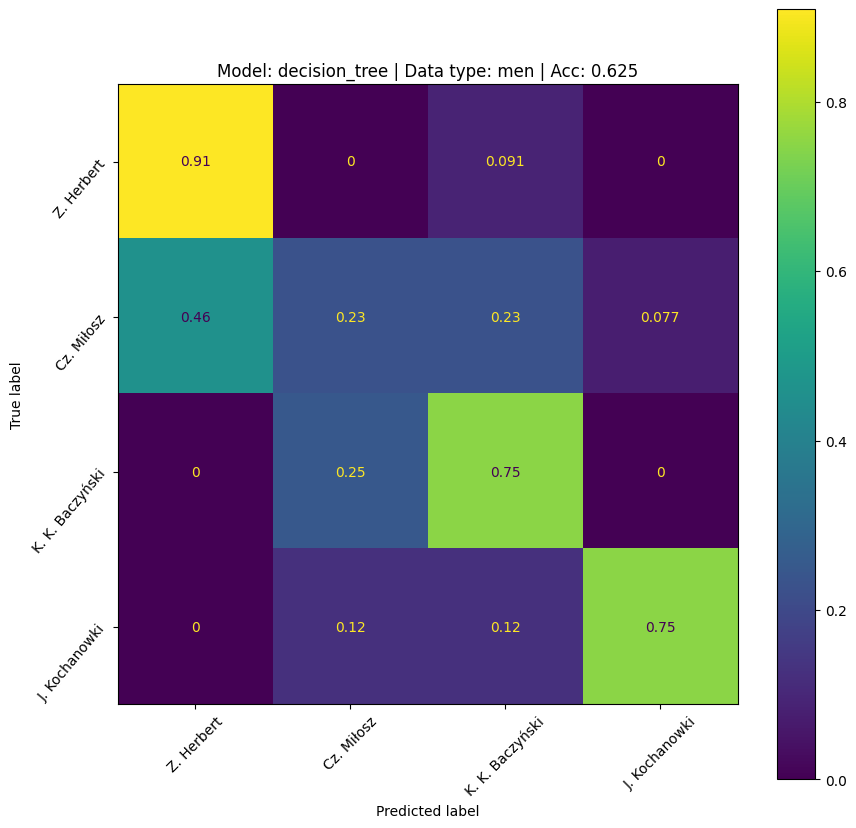

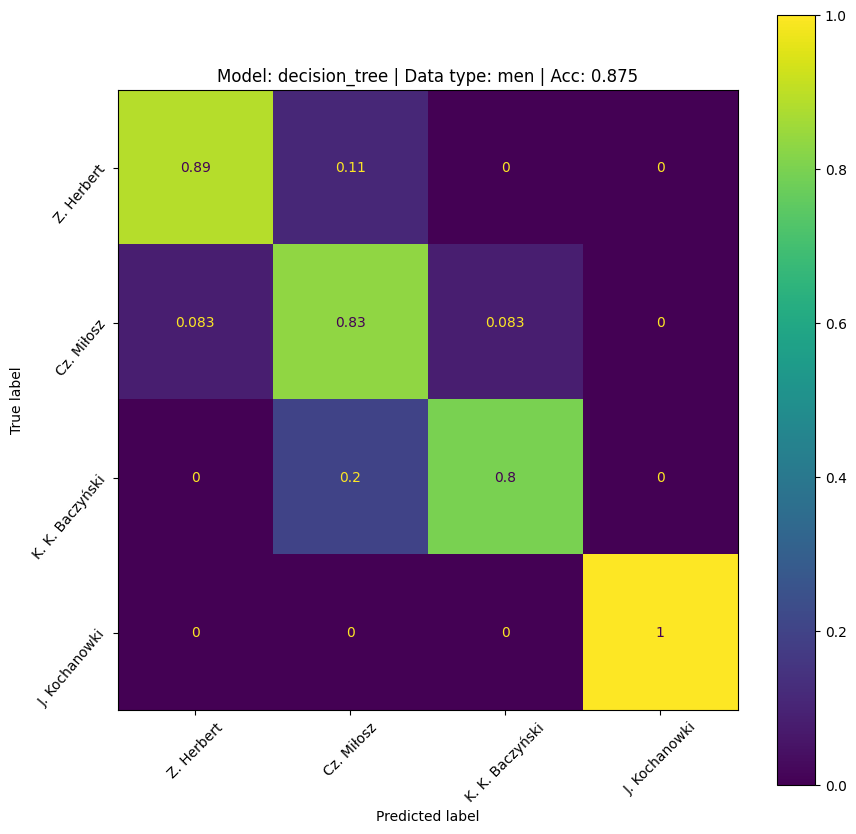

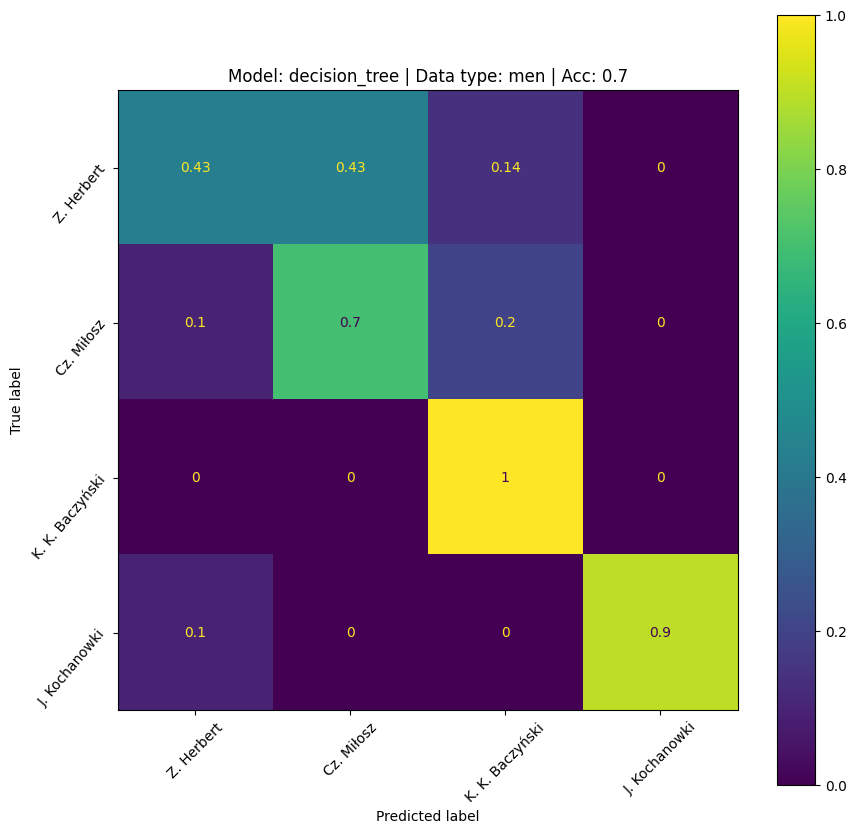

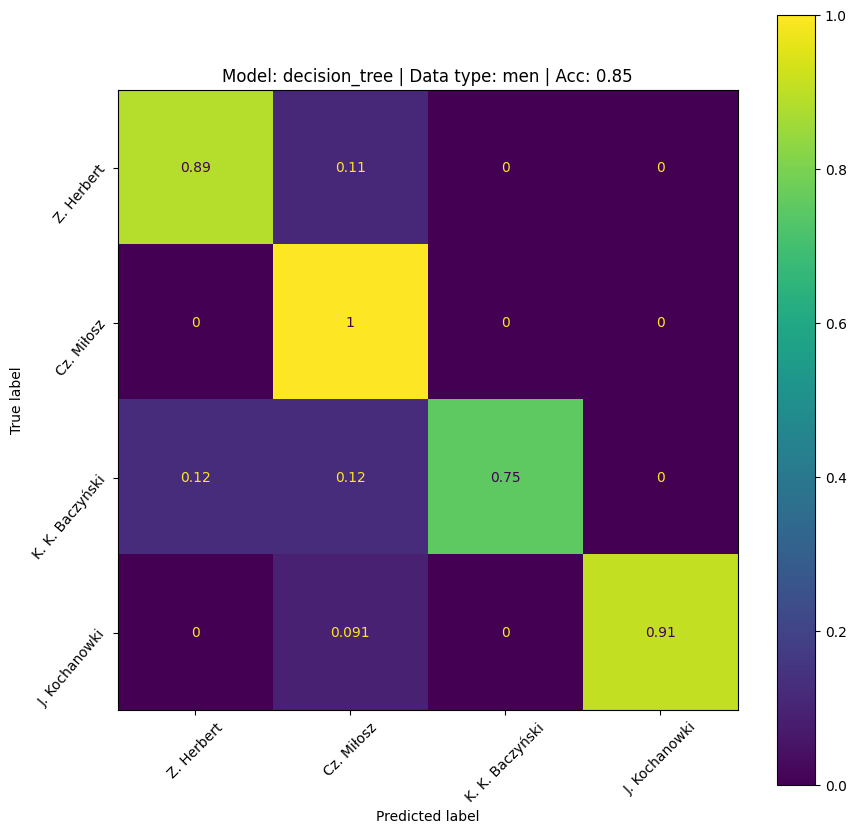

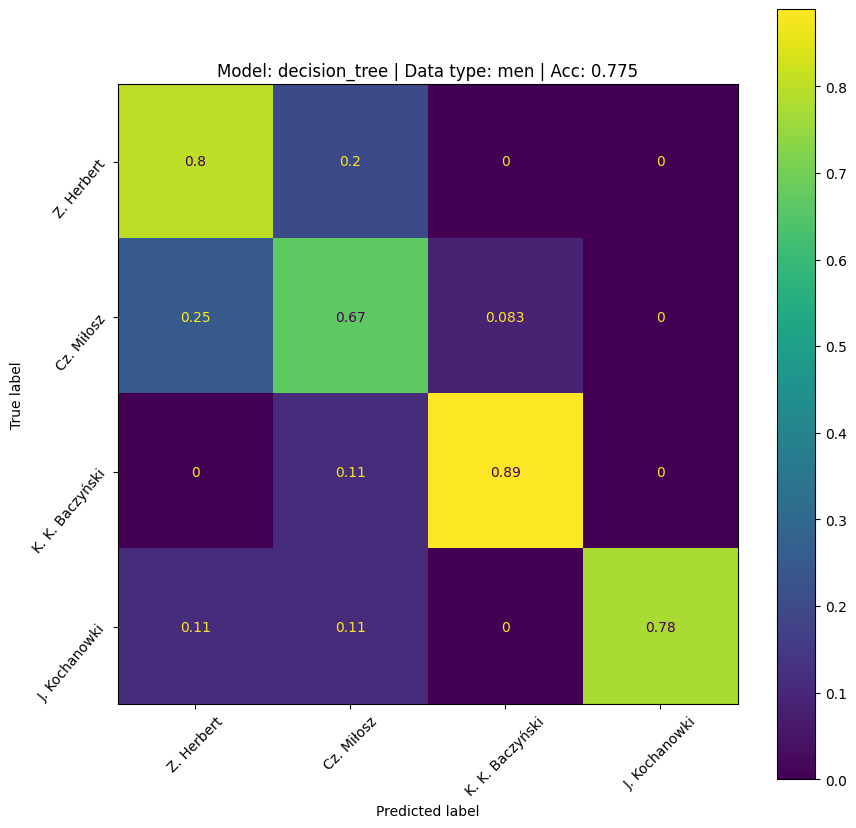

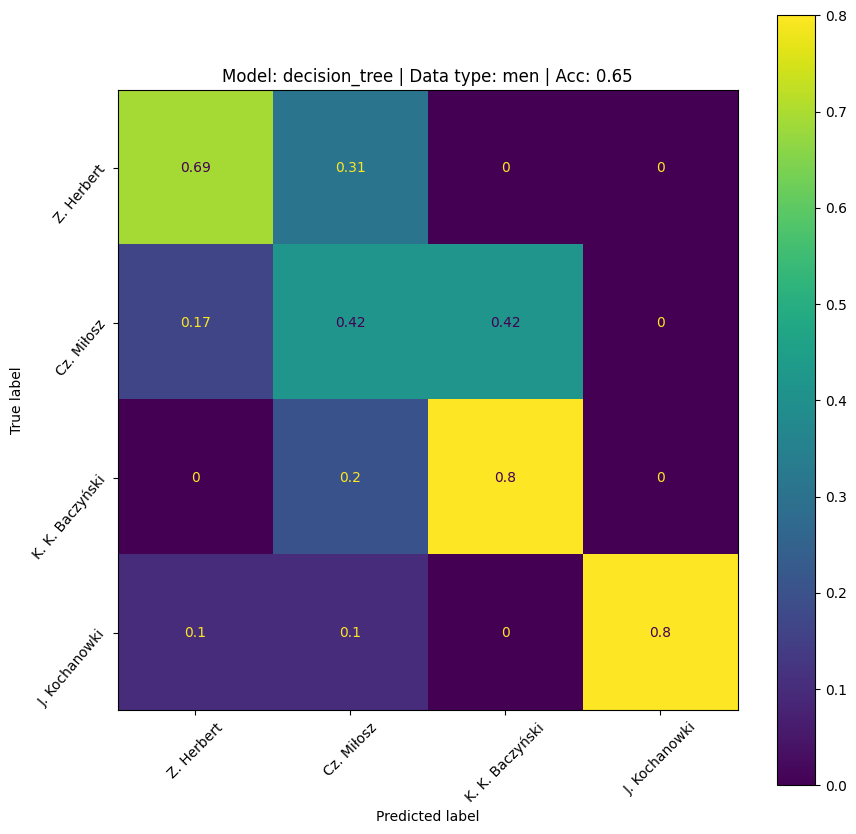

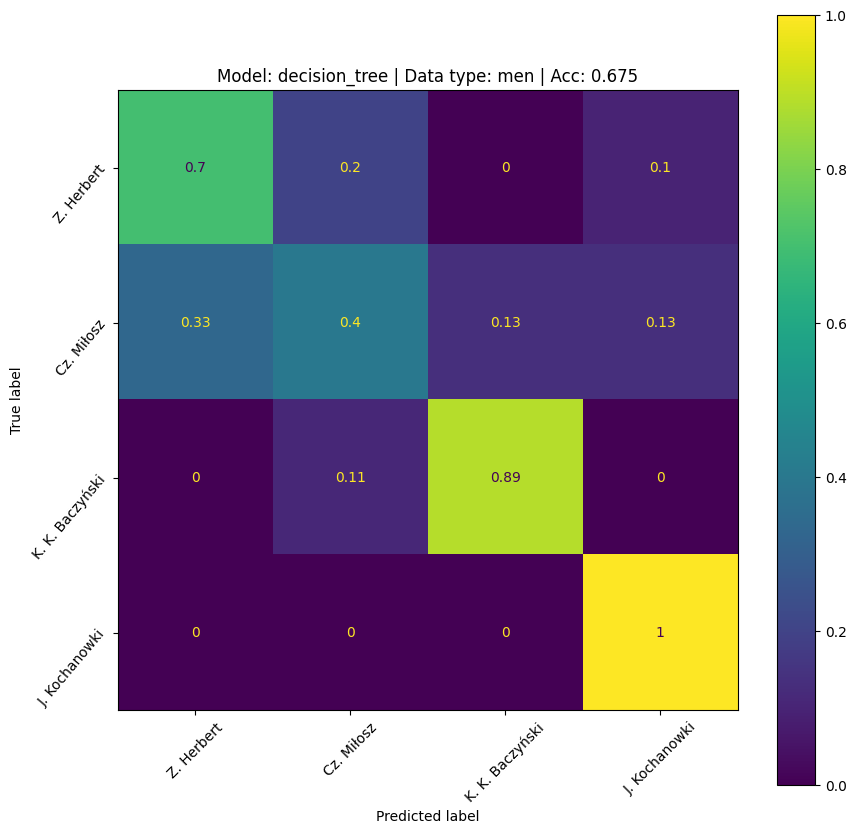

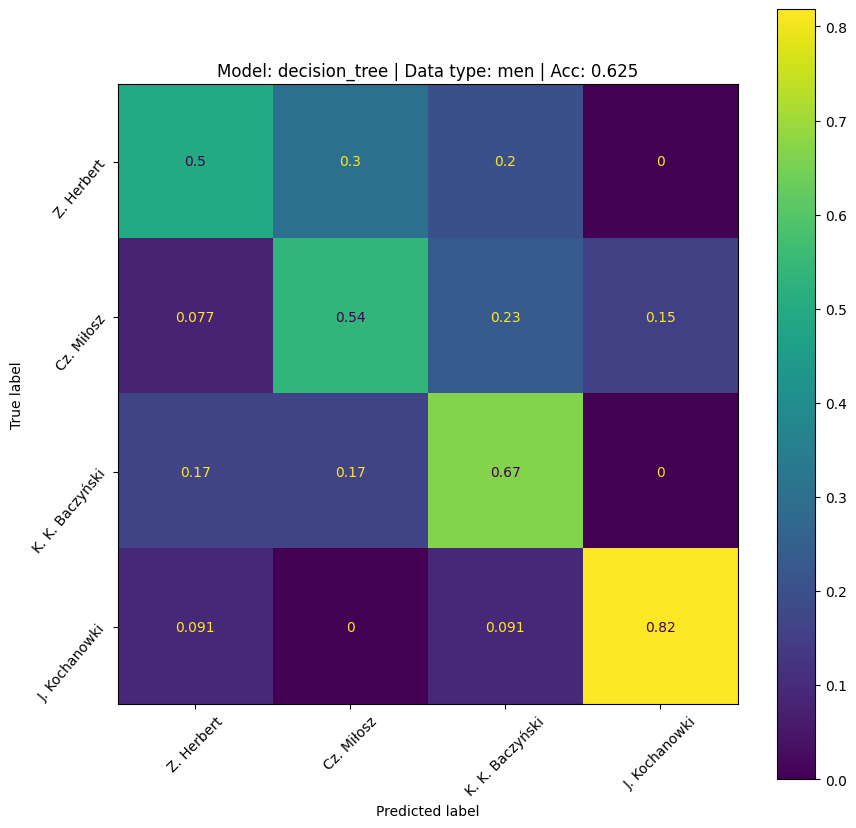

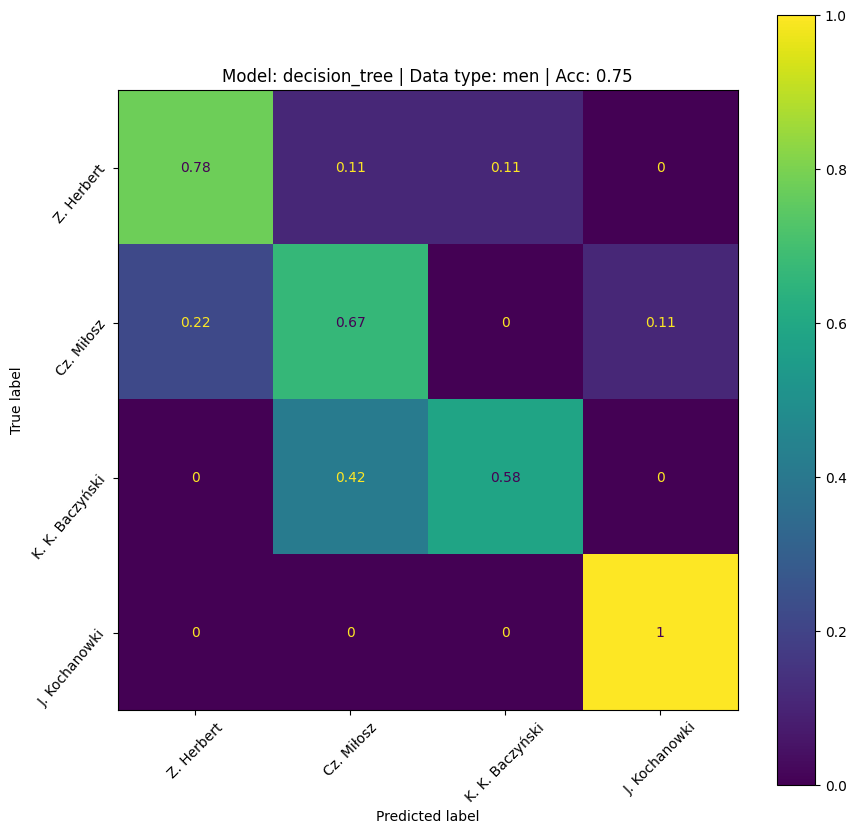

In [ ]:
df = df_men
model_name = "decision_tree"
data_type = 'men'

classes = print_classes(df)
classes
n_classes = len(classes)
n_realizations = 10
CM = np.zeros((n_classes,n_classes,n_realizations))
scores = []


for r in range(0,n_realizations):
  X, y, X_train, X_test, y_train, y_test = get_X_y_train(df, normalize=False)
  classes = print_classes(df)

  score, CM[:,:,r] = run_models(X_train, y_train, X_test, y_test, data_type, classes)
  scores.append(score)

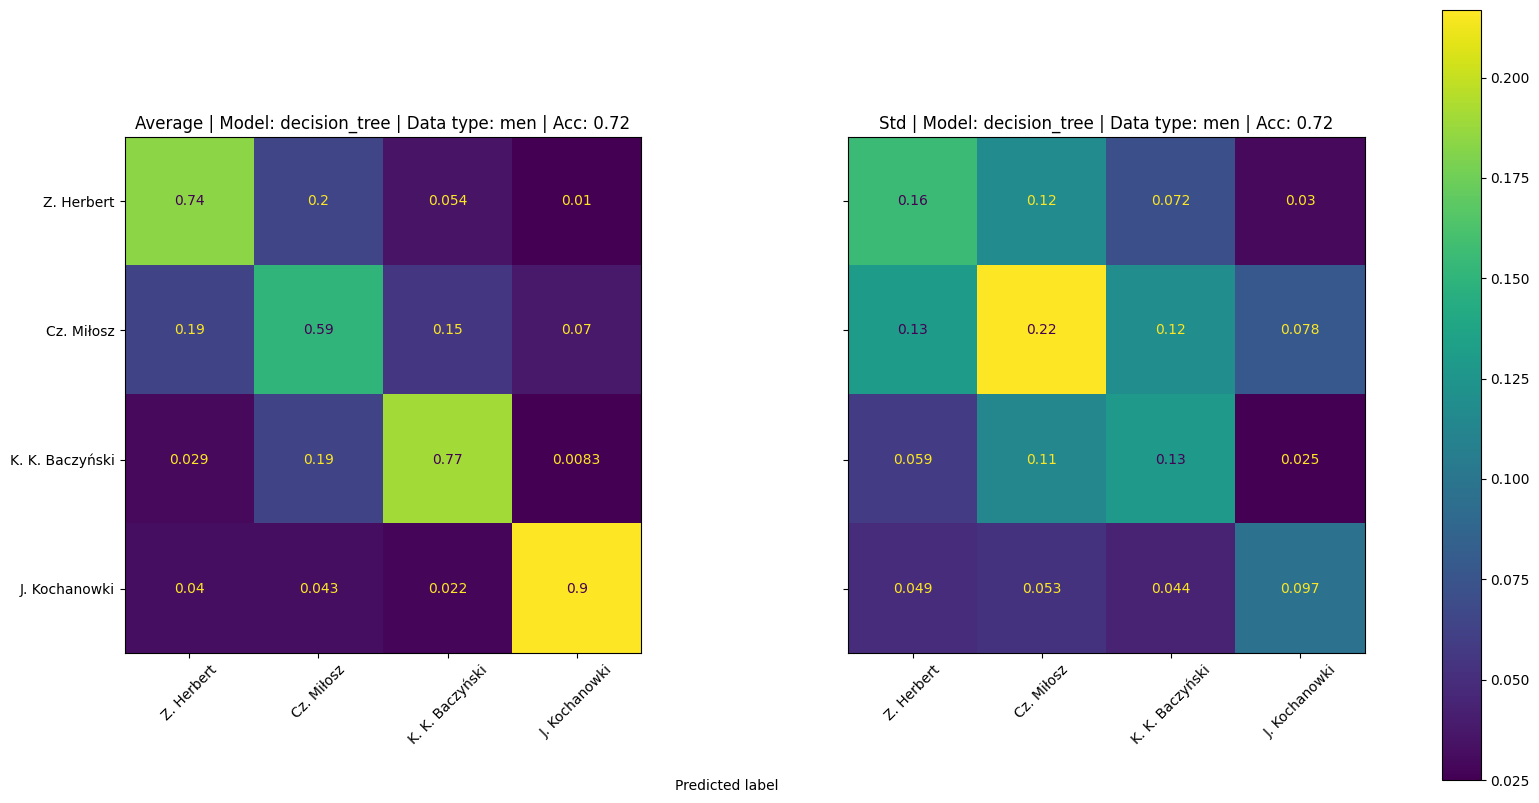

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x500 with 0 Axes>

In [ ]:
CM_avrg = np.zeros((n_classes,n_classes))
CM_std = np.zeros((n_classes,n_classes))
score_avrg = np.mean(scores)

for i in range(0,n_classes):
  for j in range(0,n_classes):
    CM_avrg[i,j] = np.mean(CM[i,j,:])
    CM_std[i,j] = np.std(CM[i,j,:])

classes = print_classes(df)
cls = []
for k in classes.keys():
  cls.append(k)

tick_marks = np.arange(4)
cms = {"Average": CM_avrg, "Std": CM_std}


fig, axes = plt.subplots(1, 2, figsize=(20,10), sharey='row')

for i, (key, cm) in enumerate(cms.items()):

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title("{} | Model: {} | Data type: {} | Acc: {}". format(key, model_name, data_type, round(score_avrg, 2)))
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  disp.ax_.set_ylabel('')


fig.text(0.40, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

fig.colorbar(disp.im_, ax=axes)
plt.show()

plt.gcf().set_size_inches(10, 5)
fig.savefig('/content/figs/avrg_{}_{}.png'.format(model_name, data_type), dpi=200)
files.download('/content/figs/avrg_{}_{}.png'.format(model_name, data_type))

In [ ]:
model_clf = DecisionTreeClassifier(max_depth=20)
%time scores = model_clf.fit(X_train, y_train)

model_name = "decision_tree"
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

CPU times: user 75.8 ms, sys: 3 µs, total: 75.8 ms
Wall time: 75.4 ms


In [ ]:
model_clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
%time scores = model_clf.fit(X_train, y_train)

model_name = 'random_forest'
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

CPU times: user 304 ms, sys: 0 ns, total: 304 ms
Wall time: 302 ms


In [ ]:
model_clf = xgb.XGBClassifier(n_estimators=100, random_state=0)
%time scores = model_clf.fit(X_train, y_train)

model_name = 'xgboost'
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

CPU times: user 17.8 s, sys: 25 ms, total: 17.9 s
Wall time: 910 ms


In [ ]:
model_clf = lgb.LGBMClassifier(n_estimators=50, random_state=0, max_depth=10)
%time scores = model_clf.fit(X_train, y_train)

model_name = 'lgbm'
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

CPU times: user 18.9 s, sys: 31.3 ms, total: 19 s
Wall time: 987 ms
